# Worksheet 17

Name: Jialong Ke, Yuchen Chao, Zihan Li, Jingbo Wang  
UID: U56019478, U51424608, U83682995, U04536921  

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

1. Data Collection and Preparation: Collect binary like/dislike data across all users and movies.
2. Similarity Calculation: Calculate the similarity between movies based on the pattern of likes and dislikes they receive. This can be done using similarity metrics such as Jaccard similarity, Cosine similarity, or Pearson correlation tailored for binary data.
3. Recommendation Generation: For a given user, identify movies that they haven't interacted with yet. Rank these movies based on their similarity to movies the user has liked. Recommend the top-ranked movies.
4. Model Evaluation: Use techniques like cross-validation and metrics such as accuracy, precision, recall, or F1 score to evaluate and fine-tune the recommender system.

b) Describe 3 challenges of building a recommender system

1. Data Sparsity: Most users typically interact with only a small subset of the total items available (e.g., movies, books), leading to a user-item interaction matrix that is mostly empty. This sparsity makes it difficult to find similar users or items and to make accurate predictions.
2. Scalability: As the user base and the number of items in the system grow, the computational complexity of generating recommendations increases. Efficiently processing these large datasets within a reasonable time frame is challenging and often requires sophisticated data structures and algorithms.
3. Cold Start Problem: This challenge arises when new users or items are added to the system. New users have no history of interactions, making it hard to predict their preferences. Similarly, new items have little or no interactions from users, making it difficult to recommend them accurately. This issue often necessitates the use of hybrid recommender systems or the incorporation of metadata to mitigate the lack of interaction data.

c) Why is SVD not an option for collaborative filtering?

SVD (Singular Value Decomposition) is typically not used directly for collaborative filtering primarily due to the issue of handling missing data. In collaborative filtering, the user-item interaction matrix is usually sparse, meaning most of the entries are unknown or unrated. Standard SVD requires a fully populated matrix and does not natively accommodate missing values, which makes it unsuitable for directly applying to a typical sparse matrix found in collaborative filtering scenarios.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  1.4329779623849463


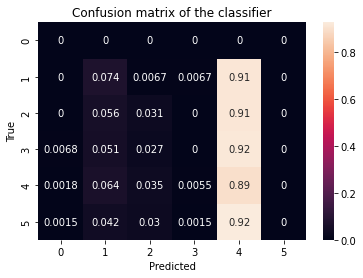

In [9]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score", 
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it


# rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()
# X_test_processed['Score'] = rec['prediction'].values.reshape(-1, 1)

# print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

# cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
# sns.heatmap(cm, annot=True)
# plt.title('Confusion matrix of the classifier')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
# Calculate the mean score from the training data
mean_score = Y_train.mean()

# Generate predictions for the test set
test_df = spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])
predictions_df = rec_sys.transform(test_df)

# Convert predictions to pandas and merge with the original test DataFrame
predictions_pd = predictions_df.toPandas()
X_test_processed = X_test_processed.merge(predictions_pd, on=['UserId_fact', 'ProductId_fact'], how='left')

# Replace NaN predictions with the mean score
X_test_processed['prediction'].fillna(mean_score, inplace=True)

# Now use the 'prediction' column instead of the original 'Score' column for further analysis
print("Kaggle RMSE = ", mean_squared_error(X_test_processed['prediction'], Y_test, squared=False))

# Generate the confusion matrix
cm = confusion_matrix(Y_test, X_test_processed['prediction'].round(), normalize='true')  # Using rounded predictions
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
